# Example T20: W Brace with Reduced cross-section

This example shows the computation of the factored tension resistance of a W shape used as a tension
member in a lateral brace in a building such as that shown in the following photo.  There are 4 braces
shown.  Note that the upper left brace has the flange tips removed from the W-shape (to ensure 
ductility under seismic forces).  We will compute the strength of a brace similar to that shown
in the photo.

In [1]:
from Obsolete_Designer import show, DesignNotes, SST, CMPart as Part, figure

![Figure](../../../images/tension/T20/DSC6443-small.jpg)

#### Load and Setup the Library Modules

In [2]:
import pint                  # setup to use the module for computing with units
ureg = pint.UnitRegistry()
mm = ureg['mm']
inch = ureg['inch']
kN = ureg['kN']
MPa = ureg['MPa']
ureg.default_format = '~P'

In [3]:
notes = DesignNotes('Tr',trace=True,units=kN)      # initial the note/record keeping object
RECORD = notes.record     # useful abbreviations
CHECK = notes.check

## Problem Statement

Compute the factored tension resistance, $T_r$, of the following assembly.  Steel is G40.21 350W and bolts are 3/4" ASTM A325 in 22mm punched holes.

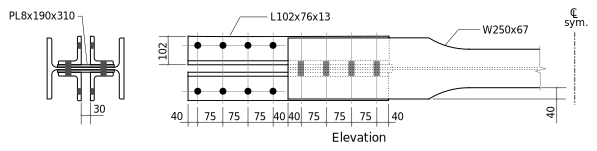

In [4]:
figure("brace1.svg")

Note that 40mm is cut from each flange tip of the W250x67.

## Angles

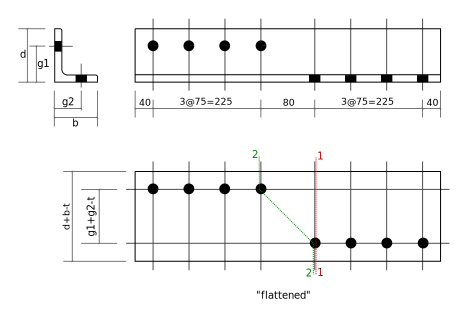

In [5]:
figure("angle.svg")

In [6]:
Bolts = Part( "Bolts",
            grade = 'ASTM A325',
            size = '3/4"',
            bd = (3/4*inch).to(mm),
            Fub = 825*MPa,
            )
Bolts.Ab = 3.14159*Bolts.bd**2/4.

with Bolts:
    show('grade,size,bd,Fub,Ab')

grade = ASTM A325 
size  = 3/4"      
bd    = 19.05     mm
Fub   = 825       MPa
Ab    = 285       mm²


In [7]:
Fy = 350
Fu = 450
d,b,t,Ag,Dsg = SST.section('L102x76x13','D,B,T,A,Dsg')
Angles = Part( "Angles",
              grade = 'CSA G40.21 350W',
              Fy = 350*MPa,
              Fu = 450*MPa,
              size = Dsg,
              d = d*mm,
              b = b*mm,
              t = t*mm,
              Ag = Ag*mm*mm,
              ha = (22 + 2)*mm,  # hole allowance  - punched holes
              g1 = 65*mm,      # gauge, longer leg
              g2 = 45*mm,      # gauge, shorter leg
              s = 80*mm,       # dist between innermost holes on each end
             )
with Angles:
    show('grade,Fy,Fu,size,d,b,t,Ag,g1,g2,s,ha',object=Angles)

grade = CSA G40.21 350W 
Fy    = 350        MPa
Fu    = 450        MPa
size  = L102x76x13 
d     = 102        mm
b     = 76.2       mm
t     = 12.7       mm
Ag    = 2100       mm²
g1    = 65         mm
g2    = 45         mm
s     = 80         mm
ha    = 24         mm


### Check Details (TO BE DONE!)
* Bolt spacings, edge distances
* Fit within flanges (need gusset thickness)

In [8]:
CHECK(False,'Bolting and fitting details have not been checked.')

    Bolting and fitting details have not been checked.?  NG! *****
      ()


### Net Section Fracture:

In [9]:
with Angles:
    # gross width = "flattened" width of angle:
    wg = d + b - t

    # failure path 1-1: 1 hole
    wn1 = wg - 1*ha

    # failure path 2-2: 2 holes
    g = g1 + g2 - t
    wn2 = wg - 2*ha + s**2/(4*g)

    wn = min(wn1,wn2)
    show('wg,g,s,wn1,wn2,wn')

wg  = 165.5 mm
g   = 97.3  mm
s   = 80    mm
wn1 = 141.5 mm
wn2 = 133.9 mm
wn  = 133.9 mm


In [10]:
with Angles:
    An = wn*t
    Ane = 0.8*An   # S16-14: 12.3.3.2 (b) (i) - connected 1 leg 4 lines of bolts
    phiu = 0.75
    Tr = 4. * phiu*Ane*Fu    # S16-14: 13.2 a) iii)
    RECORD(Tr,'Net section fracture, 4 angles','An,Ane,Tr,Fu');

    Net section fracture, 4 angles: Tr = 1837 kN    <<<--- GOVERNS
       (An=1701mm², Ane=1361mm², Fu=450MPa)

### Gross Section Yield:

In [11]:
with Angles:
    phi = 0.9
    Tr = 4. * phi*Ag*Fy    # S16-14: 13.2 a) i)
    RECORD(Tr,'Gross section yield, 4 angles','Ag,Fy,Tr');

    Gross section yield, 4 angles: Tr = 2646 kN
       (Ag=2100mm², Fy=350MPa)

### Block Shear

In [12]:
with Angles:
    Agv = (40*mm + 3*75*mm)*t
    An = (min(d-g1,b-g2) - ha/2.)*t
    Ut = 0.3
    phiu = 0.75
    Tr = 4. * phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)
    RECORD(Tr,'Block shear, 4 angles','Ut,An,Agv,Tr');

    Block shear, 4 angles: Tr = 2522 kN
       (Ut=0.3, An=243.8mm², Agv=3366mm²)

## Tr for W Shape

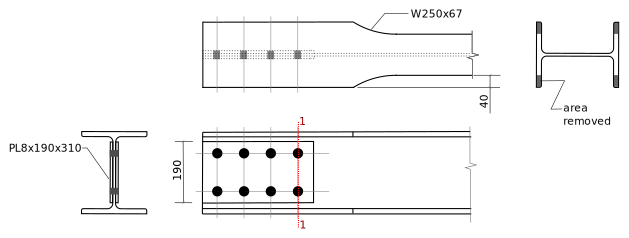

In [13]:
figure("w.svg")

In [14]:
Ag,b,d,t,w,Dsg = SST.section('W250x67',properties='A,B,D,T,W,Dsg')

WShape = Part( "WShape",
            grade = 'ASTM A992',
             Fy = 345*MPa,
             Fu = 450*MPa,
             size = Dsg,
             Ag = Ag*mm*mm,
             b = b*mm,
             d = d*mm,
             t = t*mm,
             w = w*mm,
              wp = 190*mm,          # width of web reinforcing PL
              tp = 8*mm,            # thickness of web reinforcing PL
              wc = 40*mm,           # width cut from flange tips
             )

with WShape:
    show('grade,size,Fy,Fy,Ag,b,d,t,w,wp,tp,wc')

grade = ASTM A992 
size  = W250x67   
Fy    = 345       MPa
Fy    = 345       MPa
Ag    = 8550      mm²
b     = 204       mm
d     = 257       mm
t     = 15.7      mm
w     = 8.9       mm
wp    = 190       mm
tp    = 8         mm
wc    = 40        mm


### Net section fracture

In [15]:
# Path 1-1: net = gross  +  plates  -  holes
with Angles,WShape:
    An = Ag  +  2*tp*wp   -  2*ha*(w+tp+tp)
    Ane = 0.85*An    # S16-14: 12.3.3.2 (c) (i)
    phiu = 0.75
    Tr = phiu*Ane*Fu
    RECORD(Tr,'Net section fracture, W shape','Ag,ha,w,tp,An,Ane,Tr');

    Net section fracture, W shape: Tr = 2982 kN
       (Ag=8550mm², ha=24mm, w=8.9mm, tp=8mm, An=10390mm², Ane=8836mm²)

### Gross section yield

In [16]:
with WShape:
    Agr = Ag - 4*wc*t   # reduced area due to flange cuts
    phi = 0.9
    Tr = phi*Fy*Agr     # S16-14: 13.2 a) i)
    RECORD(Tr,'Gross section yield, W shape','Agr,Tr');

    Gross section yield, W shape: Tr = 1875 kN
       (Agr=6038mm²)

### Block Shear

In [17]:
with Angles,WShape:
    T = w + tp + tp          # thickness of web + reinforcing plates
    Agv = 2*(40*mm + 3*75*mm)*T
    An = (g2 + g2 + 25*mm - ha)*T   # estimate 25mm spacing between angles (gusset thickness)
    Ut = 1.0
    phiu = 0.75
    Tr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)       # S16-14: 13.11
    RECORD(Tr,'Block shear, W shape','T,Ut,An,Agv,Tr');

    Block shear, W shape: Tr = 3125 kN
       (T=24.9mm, Ut=1.0, An=2266mm², Agv=13200mm²)

### Tearout

In [18]:
with WShape:
    Agv = 4*(40*mm + 3*75*mm)*T
    An = 0*mm*mm
    Ut = 1.0
    phiu = 0.75
    Tr = phiu*(Ut*An*Fu + 0.6*Agv*(Fy+Fu)/2.)       # S16-14: 13.11
    notes.record(Tr,'Tearout, W shape','Ut,An,Agv,Tr');

    Tearout, W shape: Tr = 4721 kN
       (Ut=1.0, An=0mm², Agv=26390mm²)

## Summary

In [19]:
notes.summary()


Summary of DesignNotes for Tr

Checks:
-------
    Bolting and fitting details have not been checked.?   NG! *****
      ()

Values of Tr:
-------------
    Net section fracture, 4 angles: Tr = 1840 kN    <<<--- GOVERNS
    Gross section yield, 4 angles:  Tr = 2650 kN
    Block shear, 4 angles:          Tr = 2520 kN
    Net section fracture, W shape:  Tr = 2980 kN
    Gross section yield, W shape:   Tr = 1870 kN
    Block shear, W shape:           Tr = 3130 kN
    Tearout, W shape:               Tr = 4720 kN

    Governing Value:
    ----------------
       Tr = 1840 kN


## To do:

- check bolt detailing
- check fit of angles between flanges
- bolts, shear
- bolts, bearing
- weld, reinforcing plates to web
- thickness of gusset plate. Bolts allow 100-45-45 = 10mm.  too little.

## Notes
* Note that gross section yield of the W should govern, but it does not by a small margin.  One thing to try would be slightly larger angles. Perhaps L127x76x13 (which would not require any additional space between flanges).  Or could shave a few more millimeters from flange tips.  Of course, all this has to be compared with factored applied loads.